In [13]:
import random
from math import cos
from copy import deepcopy
from functools import partial

from tqdm import tqdm_notebook

from tile_coding import IHT, tiles


def bound(value, boundary):
    lower, upper = boundary
    return min(max(value, lower), upper)


# TODO: rbf
def tile_code(S, A, iht=IHT(4096), num_tilings=8):
    position, velocity = S
    return tiles(iht, num_tilings, [num_tilings * position / (0.5 + 1.2),
                                    num_tilings * velocity / (0.07 + 0.07)], [A])


class Mountain():
    def __init__(self, position_boundary, velocity_boundary):
        self.position_boundary = position_boundary
        self.velocity_boundary = velocity_boundary
        self.reward = -1

    def transition(self, S, A):
        position, velocity = S
        new_velocity = bound(velocity + 0.001 * A - 0.0025 * cos(3 * position),
                     self.velocity_boundary)
        new_position = bound(position + new_velocity, self.position_boundary)
        if new_position == self.position_boundary[0]:
            new_velocity = 0.
        S_prime = (new_position, new_velocity)
        return self.reward, S_prime


class Linear():
    def __init__(self, f_extractor, f_dim):
        self.f_extractor = f_extractor
        self._initialize_w(f_dim)

    def _initialize_w(self, f_dim):
        self.w = [0. for _ in range(f_dim)]

    def __call__(self, S, A):
        features = self.f_extractor(S, A)
        return sum(self.w[f] for f in  features) # dot product

    def gradient(self, S, A):
        return self.f_extractor(S, A) # x(S, A)


class GradientSARSA():
    def __init__(self, alpha, gamma=1):
        self.alpha = alpha
        self.gamma = gamma

    def __call__(self, q_hat, S, A, R, S_prime=None, A_prime=None):
        if S_prime is None and A_prime is None: # terminal
            for f in q_hat.gradient(S, A):
                q_hat.w[f]  += self.alpha * (R - q_hat(S, A))
        else:
            for f in q_hat.gradient(S, A):
                q_hat.w[f]  += self.alpha *\
                               (R + self.gamma * q_hat(S_prime, A_prime) -
                                q_hat(S, A))


class GreedyPolicy():
    def __init__(self, actions, eps=None):
        self.actions = actions
        self.eps = eps

    def __call__(self, q_hat, S, is_test=False):
        if is_test: self.eps = 0
        if random.random() < self.eps: # explore
            return random.choice(list(self.actions))
        else: # act greedily
            q = [q_hat(S, a) for a in self.actions]
            return self.actions[q.index(max(q))]


def initialize_S(position_range=(-0.6, -0.4), velocity=0):
    position = random.uniform(*position_range)
    return (position, velocity)


if __name__ == "__main__":

    tiling_size = 4096
    num_tilings = 8
    pos_boundary = (-1.2, 0.5)
    vel_boundary = (-0.07, 0.07)
    actions = (-1, 0, 1)
    alpha = 0.3 / num_tilings
    eps = 0. # why?
    num_episodes = 9000

    f_extractor = partial(tile_code, iht=IHT(tiling_size), num_tilings=num_tilings)
    linear = Linear(f_extractor, f_dim=tiling_size)
    mountain = Mountain(pos_boundary, vel_boundary)
    eps_greedy = GreedyPolicy(actions, eps)
    grad_sarsa = GradientSARSA(alpha)

    to_plot = {}
    for i in tqdm_notebook(range(1, num_episodes+1)):
        #print('episode num: {} / {}'.format(i, num_episodes))
        S = initialize_S()
        A = eps_greedy(linear, S)
        step = 0
        while True:
            step += 1
            R, S_prime = mountain.transition(S, A)
            if S_prime[0] == pos_boundary[1]: # terminal
                #print('episode finished at step: ', step)
                grad_sarsa(linear, S, A, R)
                step = 0
                break
            A_prime = eps_greedy(linear, S_prime)
            grad_sarsa(linear, S, A, R, S_prime, A_prime)
            S, A = S_prime, A_prime
        if i in [1, 12, 104, 1000, 9000]:
            to_plot['Episode {}'.format(i)] = deepcopy(linear)

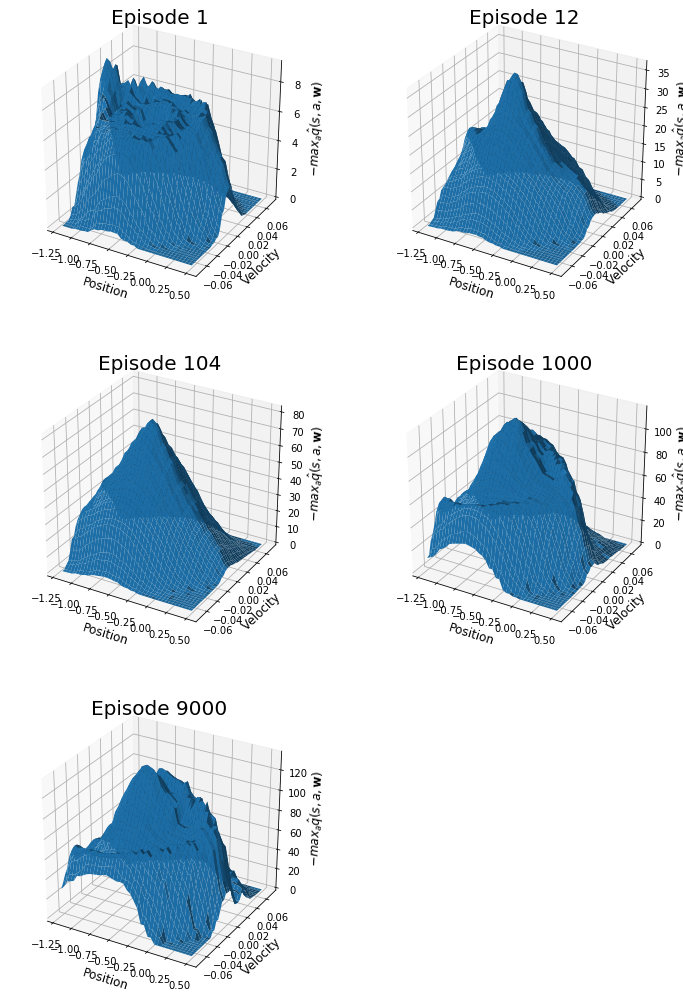

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 18))

grid = 40
position = np.linspace(*pos_boundary, grid)
velocity = np.linspace(*vel_boundary, grid)
x, y = np.meshgrid(position, velocity)

for i, (name, linear) in enumerate(to_plot.items(), 1):
    act_val = []
    for pos, vel in zip(x.reshape(-1), y.reshape(-1)):
        act_val.append(max([-1 * linear((pos, vel), a) for a in actions]))
    z = np.array(act_val).reshape(grid, grid)
    ax = fig.add_subplot(len(to_plot)//2 + 1, 2, i, projection='3d')
    ax.plot_surface(x, y, z)
    ax.set_xlabel('Position', fontsize=12)
    ax.set_ylabel('Velocity', fontsize=12)
    ax.set_zlabel('$-max_a\hat{q}(s,a, \mathbf{w})$', fontsize=12)
    ax.set_title(name, fontsize=20)
plt.show()

In [17]:
fig.savefig('result.png')